In [1]:
import numpy as np
import pandas as pd
import json
from urllib.request import urlopen
import sqlite3
import string

import seaborn as sns
import matplotlib.pyplot as plt

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
from ast import literal_eval
import statsmodels.formula.api as smf

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def handle_nan(y) :
    try :
        return literal_eval(y)

    except Exception as e:
        y = y.replace("nan", "0")
        return literal_eval(y)

In [ ]:
data_speakers = pd.read_csv('data/speaker_attribute.bz2',  compression='bz2')

In [4]:
data_speakers.columns
columns_eval = ['occupation','religion','nationality','ethnic_group','party','academic_degree','religion']

In [5]:
data_speakers[columns_eval] = data_speakers[columns_eval].applymap(handle_nan)

In [6]:
data_speakers.head(10)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate,skeptic
0,['+1732-02-22T00:00:00Z'],"[Great Britain, United States of America]",['male'],[],"[politician, slaveholder, farmer, engineer, ca...",[independent politician],[],Q23,George Washington,"['1792 United States presidential election', '...",[Episcopal Church],0,0
1,['+1952-03-11T00:00:00Z'],[United Kingdom],['male'],[White British],"[novelist, science fiction writer, children's ...",[],[],Q42,Douglas Adams,[],[],0,0
2,['+1868-08-23T00:00:00Z'],[Belgium],['male'],[],"[bibliographer, lawyer, inventor, information ...",[],[],Q1868,Paul Otlet,[],[],0,0
3,['+1946-07-06T00:00:00Z'],[United States of America],['male'],[],"[autobiographer, painter, financier, politicia...",[Republican Party],[],Q207,George W. Bush,"['2000 United States presidential election', '...","[United Methodist Church, Episcopal Church, Me...",1,1
4,['+1599-06-06T00:00:00Z'],[Spain],['male'],[],[painter],[],[],Q297,Diego Velázquez,[],[],0,0
5,['+1915-11-25T00:00:00Z'],[Chile],['male'],[],"[politician, military officer]",[independent politician],[],Q368,Augusto Pinochet,[],[Catholicism],0,0
6,['+1821-04-09T00:00:00Z'],[France],['male'],[French],"[literary critic, poet, author, art critic, es...",[],[],Q501,Charles Baudelaire,[],[Catholicism],0,0
7,['+1473-02-19T00:00:00Z'],[Kingdom of Poland],['male'],[Poles],"[physician, mathematician, astronomer, jurist,...",[],[],Q619,Nicolaus Copernicus,[],[Catholicism],0,0
8,['+1945-11-12T00:00:00Z'],"[Canada, United States of America]",['male'],[],"[autobiographer, singer-songwriter, actor, gui...",[],[],Q633,Neil Young,[],[],0,0
9,['+1969-00-00T00:00:00Z'],[Germany],['male'],[],"[photographer, Wikimedian]",[],[],Q640,Harald Krichel,[],[],0,0


In [15]:
occupation = data_speakers.occupation.explode()
occup = occupation.unique()
occup.size

11768

In [16]:
occupation_repartition = occupation.value_counts()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'researcher'),
  Text(1, 0, 'politician'),
  Text(2, 0, 'association football player'),
  Text(3, 0, 'actor'),
  Text(4, 0, 'writer'),
  Text(5, 0, 'painter'),
  Text(6, 0, 'basketball player'),
  Text(7, 0, 'journalist'),
  Text(8, 0, 'university teacher'),
  Text(9, 0, 'singer'),
  Text(10, 0, 'poet'),
  Text(11, 0, 'composer'),
  Text(12, 0, 'musician'),
  Text(13, 0, 'military personnel'),
  Text(14, 0, 'lawyer'),
  Text(15, 0, 'historian'),
  Text(16, 0, 'film actor'),
  Text(17, 0, 'businessperson'),
  Text(18, 0, 'artist'),
  Text(19, 0, 'film director'),
  Text(20, 0, 'physician'),
  Text(21, 0, 'screenwriter'),
  Text(22, 0, 'botanist'),
  Text(23, 0, 'photographer'),
  Text(24, 0, 'teacher'),
  Text(25, 0, 'architect'),
  Text(26, 0, 'visual artist'),
  Text(27, 0, 'Catholic priest'),
  Text(28, 0, 'author'),
  Text(29, 0, 'tra

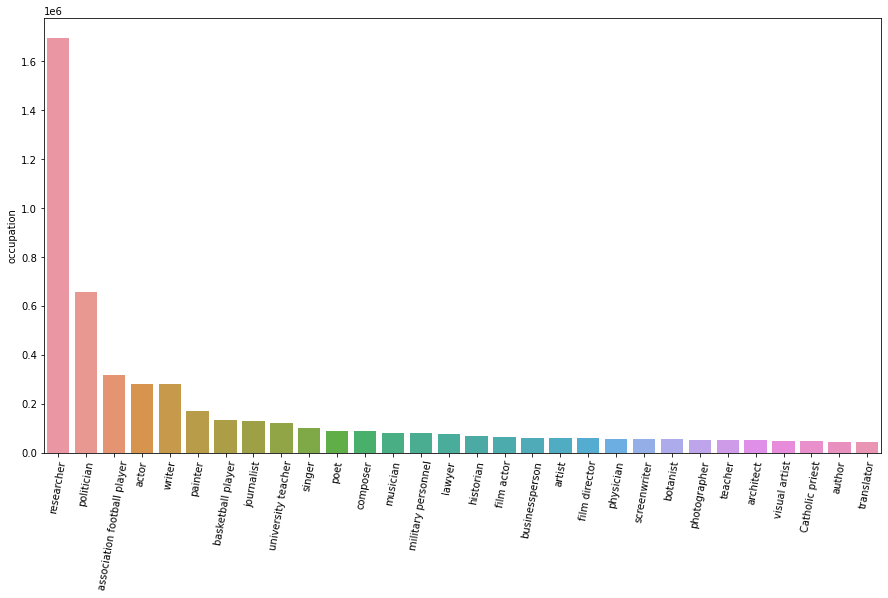

In [19]:
plot_h = occupation_repartition.head(30)
plt.figure(figsize=(15, 8))
sns.barplot(x= plot_h.index, y = plot_h)
plt.xticks(rotation = 80)

In [2]:
#This function takes a dataframe as attribute return the date and country where the speaker (second attribute) was president
#The dates in the ....-.. format are not handled yet
def get_candidacy(df,label):
    sentence = df.loc[df[df['label']==label].index.values[0],'candidacy']
    doc = nlp(sentence)
    cand = pd.DataFrame(columns=['date','country'])
    for ent in doc.ents:
        if ent.label_ == 'DATE':
            date = ent.text 
        elif ent.label_ == 'GPE':
            country = ent.text
            cand = cand.append({'date':date,'country':country},ignore_index=True)
    return cand